# Cloudfiles Demo

*This is a modified and shortened version of the LabNotebook entry [here](https://johngriffiths.github.io/LabNotebook/about-workdocs-cloudfiles.html)*

## Overview

A very nice feature of IPython/Jupyter notebooks is they allow embedded images, without the need for potentially breakable references to external image files. However, the flip-side of this is that notebooks with lots of images in become very large, and unwieldy in various ways - particularly in combination with git and github repositories. Github is not designed to be passing large binary file objects such as .png files (or notebooks with embedded .png files) as they do not diff well, and can clog up repositories causing all kinds of problems, such as obscenely slow git command line calls, warnings or downright refusals from github to accept pushes containing large files. Also, nbviewer does not work well with very large notebooks, and we very much want things to be working with nbviewer. 


Now that I'm ramping up use of the LabNotebook, it is therefore becoming apparent that a different approach to images is needed. 




Carl Boettiger's [solution to this kind of problem](http://www.carlboettiger.info/2012/03/21/knitr-github-and-a-new-phase-for-the-lab-notebook.html) is to store all images on flickr, and simply link to them. He has a very streamlined solution,  which involves knitr and hash-based file indexing. I want a similar solution to this, but with the following differences: 

- I am working with python + ipython/jupyter + nbconvert, rather than R + knitr
- I am using the ipynb-workdocs system, which involves having a master notebook that spawns into pdf files, html/nbviewer files, and reveal slideshows, with variable contents according to a per-cell tag



The solution I have come up with has two components. 

The first is a mechanism for pushing figures to a cloud storage as soon as they are added, so that they can be linked to in html and derivative nbviewer notebook, labnotebook webpages, and web-hosted reveal slideshows. The second component is a custom figure class that uses IPython's custom display logic to expose two a different command call for nbconverted latex (and subsequently compile PDFs), which links to local files rather than cloud-hosted files. 


For the cloud-hosting, I played around with the flickr python api a bit, but kept getting errors. I then turned to dropbox, and was able to get down a nicely functioning high-level wrapper that achieved the above nicely (c.f. the dropbox python api documentation [here](https://www.dropbox.com/developers/core/docs/python) and [here](https://www.dropbox.com/developers/core/start/python)). However, it subsequently came to my attention that  ***dropbox api urls expire after 30 days, unless you are a pro or business user***. As I am neither of those, my nice dropbox solution doesn't do the job for me, although it could well do for others who do pay dropbox money. So I hunted around again, and am now currently favouring amazon S3, via a nice api called `boto`. This is still not entirely free, but certainly better value for money. And, it turns out, a lot smoother to use, plus providing some additional features like website hosting. 

The code below describes the aws/boto implementation, and for good measure also the dropbox one, although as noted the latter will have only have non-broken links for up to 30 days after the time writing. 


In addition to figures, we can also use upload other useful content to the cloud-hosted folders, such as data files, nbconverted pdfs (preferable to e-mailing if these are large files), etc.

The end result that notebooks (and various nbconverted derivatives) sans all embedded images are slimmed down enormously, and things such as a github-hosted LabNotebook repository become scalable in the medium-term. 

Ok, let's get cracking:

## Notebook Setup

Define some variables

In [54]:
imfile1 = 'batwatchers_breakfast.png'
imfile2 = 'mpl3d_example.png'
movfile = 'example_movie.mp4'

nb_name = 'cloudfiles-demo'


aws_key = ''
aws_secret = ''


Importage

In [79]:
# Workdocs-cloudfiles stuff

from new_utils import nb_fig,cloudfiles_nb
from IPython.display import display as d
import os


# Visualization stuff
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d

from moviepy.editor import VideoClip
from moviepy.video.io.bindings import mplfig_to_npimage

from wand.image import Image as wi


### AWS S3

Initialize the cloud folder for this notebook, and tell it what notebook name (and so folder name) to use:

In [66]:
nb_name = 'cloudfiles-demo'

cnb_aws = cloudfiles_nb('aws', [aws_key,aws_secret])

cnb_aws.initialize_folder(nb_name)

This is what the code looks like:

```python
class cloudfiles_nb(object):
    
  def __init__(self,api_type,keys):

    self.api_type = api_type
    
    
    if api_type == 'aws': 
    
      from boto.s3.connection import S3Connection
        
      aws_key,aws_secret = keys 
      self.conn = S3Connection(aws_key, aws_secret)
        
        
        
    elif api_type == 'dropbox':
        
      from dropbox.client import DropboxClient
      from dropbox.session import DropboxSession    
 
      access_token = keys
        
      self.uploaded_files = {}
      self.client = DropboxClient(access_token)
      self.base_dir = 'workdocs-cloudfiles'        
      self.folders_list = [p['path'].replace('/%s/' %self.base_dir, '')\
                           for p in self.client.metadata(self.base_dir)['contents']]
      self.upload_file_res = {}

    
  def initialize_folder(self,folder_name):
    

    if self.api_type == 'aws':
        
      self.bucket = self.conn.create_bucket(folder_name)
      self.folder_name = folder_name
        
    
    elif self.api_type == 'dropbox':
        
      self.thisfolder = '%s/%s' %(self.base_dir,folder_name)
    
      if folder_name in self.folders_list:
        print 'folder already exists'
        res = None
      else:
        print 'creating folder'
        res = self.client.file_create_folder(self.thisfolder)
        
      # do something for error
    
      return res

    
  def upload_file(self,filepath):
        
        
    if self.api_type == 'aws':
        
      from boto.s3.key import Key
        
      filename = filepath.split('/')[-1]
    
      k = Key(self.bucket)
      k.key = filename
    
      k.set_contents_from_filename(filepath)        
      k.set_acl('public-read')        
      if '.png' in k.key: k.set_metadata('Contet-Type', 'image/png')
 
        
    elif self.api_type == 'dropbox':
        
      f = open(filepath, 'r')
      filename = filepath.split('/')[-1]

      newfile = '%s/%s' %(self.thisfolder,filename)
    
      # if filename alread exists, delate and replace
      #filecheck = self.client.search(self.thisfolder, filename)
      #if filecheck: del_res = self.client.file_delete(newfile)
          
      res = self.client.put_file(newfile, f, overwrite=True)
 
      return res

        

  def get_file_link(self,filename):
        

    if self.api_type == 'aws':
        
      thiskey = self.bucket.get_key(filename) 
      res = 'https://%s.s3.amazonaws.com/%s' %(self.bucket.name,filename)   
      # something for error
    
      return res


    elif self.api_type == 'dropbox':
        
      res = self.client.media('%s/%s' %(self.thisfolder,filename))['url']
      # something for error
   
      return res

  def get_nbviewer_link(self,filename):

    file_link = self.get_file_link(filename)
    nbv_pfx = 'http://nbviewer.ipython.org/urls'
    res = nbv_pfx + '/' + file_link.replace('https://', '')     

    return res

  def get_slideviewer_link(self,filename):

    file_link = self.get_file_link(filename)
    sv_pfx = 'https://slideviewer.herokuapp.com/urls'
    res = sv_pfx + '/' + file_link.replace('https://', '')
  
    return res
       
    
```

### Custom figure class

Just to demonstrate how to use the api, let's upload one of the image files:

The usage is fairly straightforward: when adding a figure, we provide it with the local image file, a figure label, a figure number, a figure caption, and the dropbox api object instance defined above. 

In [67]:
cap = 'Come to the batwatchers breakfast, where all is joy and happiness.'
label = 'BB figure'
fignum = '1.1'
im = nb_fig(imfile1,label,cap,cnb_aws,fignum=fignum,size=(800,500))
d(im)

This class uses the `_repr_html_` and `_repr_latex_` to essentially put different text strings into html-related and pdf-related nbconvert outputs, which refer to the uploaded cloud figures and to the original local image files, respectively. 

It will accept either the dropbox or aws cloudfiles object, and usage is now independent of which of those is being used. 



Here's what it looks like:

```python     

class nb_fig(object):


  
  def __init__(self, local_file,label,cap,api_obj,fignum=None,upload_file=True,
               size=(500,400),filetype='image',iframe_test=True,show_fignum=True):
    
    self.api_obj = api_obj
    self.local_file = local_file
    self.size = size
    self.cap = cap
    self.label = label
    self.fignum = fignum
    self.filetype=filetype
    self.show_fignum = show_fignum


    if self.show_fignum: fignum_str = 'Figure %s.' %fignum
    else: fignum_str = ''
    self.fignum_str = fignum_str

    from IPython.display import IFrame

    if upload_file:
      res1 = api_obj.upload_file(local_file)


    fname = local_file.split('/')[-1]
 
    res2 = api_obj.get_file_link(fname)
    
    self.cloud_file = res2
  
    # this is a hacky solution to an odd bug I have noticed, 
    # where after uploading an image (seems to be when this is 
    # repeated a few times), the displayed image is sometimes
    # not the latest uploaded image. This seems to be resolved 
    # by creating an IFrame with the dropbox link; so just do 
    # this here with a temporary one, and then delete immediately 
    if iframe_test:
      tmp = IFrame(self.cloud_file,width=500,height=500)
      del tmp
	
    
  def _repr_html_(self):

    if self.filetype == 'image':


      html_str = '<center><img src="%s" alt="broken link" \
                  title="%s %s. %s" height="%spx" width="%spx" />\
                  %s %s. %s </center>' %(self.cloud_file,
                                                 self.fignum_str,self.cap,self.label,
                                                 self.size[0],self.size[1],
                                                 self.fignum_str,self.label,self.cap)
    elif self.filetype == 'movie':

        
      html_str = '<center><iframe \
                  height="%s" \
                  width="%s" \
                  src="%s" \
                  frameborder="0" \
                  allowfullscreen \
                  ></iframe></center> \
                  <center>%s %s. %s</center>' %(self.size[0],self.size[1],
                                                        self.cloud_file,self.fignum_str,
                                                        self.label,self.cap)
                  


    return html_str

  # the 'newpage' here could possibly be replace with something a bit better. 
  # I put it in because otherwise figures seem to break up text and section headings
  # in rather scrappy ways. 
  def _repr_latex_(self):

    if self.filetype == 'image':

      ltx_str = r'\begin{figure}[htbp!] \centering \vspace{20pt} \begin{center} \
                  \adjustimage{max size={0.9\linewidth}{0.9\paperheight}}{%s} \
                  \end{center}{ \hspace*{\fill} \\} \caption[%s]{%s} \label{fig:%s} \
                  \end{figure} \newpage' %(self.local_file,self.label,self.cap,self.label)

    elif self.filetype == 'movie':

      ltx_str = r'\begin{figure}[htbp!] \centering \vspace{20pt} \begin{center} \
                  \includemovie[poster,text={\small(Loading Video...)}]{6cm}{4cm}{%s} \
                  \end{center}{ \hspace*{\fill} \\} \caption[%s]{%s} \label{fig:%s} \
                  \end{figure} \newpage' %(self.local_file,self.label,self.cap,self.label)


    return ltx_str 
  
    
```
  

Getting the file link is a common thing we want to do, so it has a higher-level method call that is the same for both aws and dropbox

In [75]:
res = cnb_aws.get_file_link('batwatchers_breakfast.png')

In [76]:
d(res)    

'https://cloudfiles-demo.s3.amazonaws.com/batwatchers_breakfast.png'

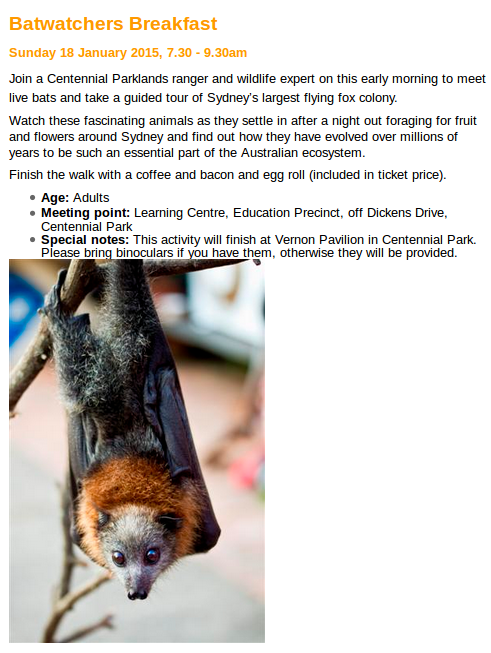

In [77]:
Image(res,embed=True)

Note a nice feature of using the html `img` tag the way we are doing is that if you hover your cursor over the image, you will see the full image title and caption flash up. Just an added tidbit :) 

Now let's generate the second figure and insert:

In [80]:
#%load http://matplotlib.org/mpl_examples/mplot3d/contourf3d_demo2.py

In [82]:
fig = plt.figure()
ax = fig.gca(projection='3d')
X, Y, Z = axes3d.get_test_data(0.05)
ax.plot_surface(X, Y, Z, rstride=8, cstride=8, alpha=0.3)
cset = ax.contourf(X, Y, Z, zdir='z', offset=-100, cmap=cm.coolwarm)
cset = ax.contourf(X, Y, Z, zdir='x', offset=-40, cmap=cm.coolwarm)
cset = ax.contourf(X, Y, Z, zdir='y', offset=40, cmap=cm.coolwarm)

ax.set_xlabel('X')
ax.set_xlim(-40, 40)
ax.set_ylabel('Y')
ax.set_ylim(-40, 40)
ax.set_zlabel('Z')
ax.set_zlim(-100, 100)

fig.savefig(imfile2,bbox_inches='tight')
plt.close()
#clear_output()

In [84]:
cap = 'This is a nice example of 3D plotting with matplotlib. '
label = 'Mplot3D figure. '
fignum = '2.1'
im = nb_fig(imfile2,label,cap,cnb_aws,fignum=fignum,size=(800,500))
d(im)

## Movies

The custom figure class also supports movies. To see this, first make a simple movie file


In [88]:
import numpy as np
import time

In [ ]:
fig, ax = plt.subplots( figsize=(6,6), facecolor=[1,1,1] )
x = np.arange(0, 2*np.pi, 0.01)
line, = ax.plot(x, np.sin(x), lw=3)

def make_frame(t):
    line.set_ydata(np.sin(x+2*t))  # update the data
    return mplfig_to_npimage(fig)

anim = VideoClip(make_frame, duration=10)

t = time.time()
anim.write_videofile(movfile, fps=20)

plt.close()

print "Animation with MoviePy : %.02f seconds"%(time.time() - t)

and insert using the figure class as above:

In [90]:
cap = 'This is a nice example of including movie files stored in the cloud, '\
       'whilst keeping the actual notebook file very lightweight'
label = 'A slightly dull movie'
fignum = '1.3'
im = nb_fig(movfile,label,cap,cnb_aws,fignum=fignum,size=(400,400),filetype='movie')
d(im)

(*I have had trouble with getting movies embedded in PDFs to play properly. Seems to require some very specific software versions and codecs. 
So am not expecting to use these movies in PDFs for at least a little while yet. This is therefore something of a 'watch this space' feature. *)))


## Using with nbconvert

The next thing to do after setting up the cloud storage api and creating the figures is run nbconvert. 

A key point here is that the way I do this is to use ipynb-workdocs to tag cells for inclusion in html, pdf, and slides outputs. In general, the pdf-tagged cells are a small subset of the html-tagged cells, as I generally want to use html for more complete code documentation, and pdfs for summaries of key results. Rough notes, personal reminders, and anything else not intended for either html, pdf, or slideshows, is simply not tagged, and remains in the master notebook for only my eyes to see. 

In this notebook I have tagged a few of the main documentation paragraphs, section headings, and the figures for inclusion in the pdf. In general I use pdfs as distilled versions of notebooks and notebook-derived html files, removing all analysis code and only leaving in discussions of results and figures. The current notebook isn't the best example of this kind of documentation approach, as there aren't any 'results' per se, indepedent of the technical run-through of the usage procedure, but it suffices to show how to use the tools nonetheless.

The nbconvert command is run separately to the cells in this notebook, but allowing that the flow has been interrupted briefly while I have run that command, let's now use the cloud api tool to upload the resulting PDF to the notebook cloud folder:

In [105]:
from tag_filter import read_notebook,write_notebook,filter_notebook_data

nb_pfx = 'cloudfiles_demo'
master_nb = '%s__master_nb.ipynb' %nb_pfx
mother_nb = '%s__mother_nb.ipynb' %nb_pfx
pdf_nb = '%s__pdf_nb.ipynb' %nb_pfx
slides_nb = '%s_slides_nb.ipynb' %nb_pfx
html_nb = '%s__html_nb.ipynb' %nb_pfx


# Make mother notebook
master_nb_dat = read_notebook(master_nb)
mother_nb_dat = filter_notebook_data(master_nb_dat,['rough_notes'], exclude=True)
write_notebook(mother_nb,mother_nb_dat)

# Make PDF notebook
pdf_nb_dat = filter_notebook_data(mother_nb_dat,
                                  list_of_tags=['rough_notes','omit_pdf', 'slides_only', 'html_only'],
                                  exclude=True)
write_notebook(pdf_nb,pdf_nb_dat)

# Make HTML notebook
html_nb_dat = filter_notebook_data(mother_nb_dat,
                                  list_of_tags=['rough_notes','omit_html', 'slides_only', 'pdf_only'],
                                  exclude=True)
write_notebook(html_nb,html_nb_dat)

# Make slides notebook
slides_nb_dat = filter_notebook_data(mother_nb_dat,
                                  list_of_tags=['rough_notes','omit_slides', 'html_only', 'pdf_only'],
                                  exclude=True)
write_notebook(slides_nb,slides_nb_dat)

In [107]:
nbc_cmd = 'jupyter nbconvert --to pdf %s' % pdf_nb
! $nbc_cmd

[NbConvertApp] Converting notebook cloudfiles_demo__pdf_nb.ipynb to pdf
Traceback (most recent call last):
  File "/alexandra/mcintosh_lab/john/Software/miniconda2/envs/_jupyter/bin/jupyter-nbconvert", line 11, in <module>
    sys.exit(main())
  File "/alexandra/mcintosh_lab/john/Software/miniconda2/envs/_jupyter/lib/python2.7/site-packages/jupyter_core/application.py", line 266, in launch_instance
    return super(JupyterApp, cls).launch_instance(argv=argv, **kwargs)
  File "/alexandra/mcintosh_lab/john/Software/miniconda2/envs/_jupyter/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/alexandra/mcintosh_lab/john/Software/miniconda2/envs/_jupyter/lib/python2.7/site-packages/nbconvert/nbconvertapp.py", line 325, in start
    self.convert_notebooks()
  File "/alexandra/mcintosh_lab/john/Software/miniconda2/envs/_jupyter/lib/python2.7/site-packages/nbconvert/nbconvertapp.py", line 493, in convert_notebooks
    self.convert

In [95]:
nbc2slides_template = 'nbc_tpl__slides_reveal_output_toggle.tpl'
nbc_cmd = 'jupyter nbconvert --to slides --template %s %s' %(nbc2slides_template, slides_nb)
! $nbc_cmd

[NbConvertApp] Converting notebook cloudfiles_demo_slides_nb.ipynb to slides
[NbConvertApp] Writing 1000907 bytes to cloudfiles_demo_slides_nb.slides.html


In [97]:
pdf_file = pdf_nb.replace('_nb.ipynb', '.pdf')

In [44]:
cnb_aws.upload_file(pdf_file)

We can grab the download link for the PDF: 
    

In [45]:
pdf_link = cnb_aws.get_file_link(pdf_file)
d(pdf_link)

'https://about_workdocs-cloudfiles.s3.amazonaws.com/about_workdocs-cloudfiles__pdf_nb__2015-07-09_tidied.pdf'

As the PDF is only short, we'll also, for completeness, insert it into the notebook (but not the pdf itself; i.e. the following cell is tagged 'html' but not 'pdf'):

In [108]:
#for page in np.arange(0,5):
#  print '\n\nPDF Page %s' %(page+1)
#  d(wi(filename=pdf_file + '[%s]' %page))

We can do the same with the (html tag-filtered) notebook, so that it can be viewed via [nbviewer](http://nbviewer.ipython.org)

In [110]:
cnb_aws.upload_file(html_nb)

In [111]:
html_nb_link = cnb_aws.get_file_link(html_nb)
d(html_nb_link)

'https://cloudfiles-demo.s3.amazonaws.com/cloudfiles_demo__html_nb.ipynb'

In [112]:
nbv_link = cnb_aws.get_nbviewer_link(html_nb)
d(nbv_link)

'http://nbviewer.ipython.org/urls/cloudfiles-demo.s3.amazonaws.com/cloudfiles_demo__html_nb.ipynb'

And voila, that link gives a pleasantly styled html render of the notebook. Whilst the content is mostly the same as the LabNotebook webpage, this format can be more useful for some purposes, and can be downloaded and run and/or modified directly. rather than copy-pasting code, For the purposes of reproducibility and open science (which is what the LabNotebook is all about, really), this would be the relevant link to share <a href="#fn:links" rel="footnote">[1]</a>. 


(Note:  unfortunately, weirdly, it appears that the dropbox api will not accept files for 
  upload with the extension '.ipynb', or even '.json'. It will accept '.txt' files, 
 however, and nbviewer will still render those files properly. So to do the above with dropbox, one first needs to rename the .ipynb files to e.g. .txt. The above calls will then work fine, although bear in mind that if downloading the file from the link, the extension should be changed back to .ipynb for the files to work properly)
 

Similarly, we can get a slideviewer link

In [102]:
sv_link = cnb_aws.get_slideviewer_link(html_nb)
d(sv_link)

'https://slideviewer.herokuapp.com/urls/cloudfiles-demo.s3.amazonaws.com/cloudfiles_demo__html_nb.ipynb'

Obviously, this entry isn't particularly intended for slideshow purposes, and I haven't made any particular effort to optimize the contents to fit slideshow dimensions etc; so the slideshow link is just a toy example of how a presentation would be constructed from a multi-section notebook <a href="#fn:slides" rel="footnote">[2]</a>. 

...and yes, you guessed it - these are the three links displayed at the top :)

Ok, that's a wrap!

---